In [16]:
import pandas as pd
import numpy as np

# Cargar los datos
df = pd.read_csv("ibex_clean.csv")  # Reemplaza con la ruta a tus datos
df['Date'] = pd.to_datetime(df['Date'])  # Asegurarse de que la fecha esté en formato datetime
df.set_index('Date', inplace=True)  # Establecer la columna de fecha como índice

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
train_size = int(len(df) * 0.8)  # Usar el 80% de los datos para entrenamiento
train = df[:train_size]
test = df[train_size:]


In [17]:
from sklearn.preprocessing import MinMaxScaler

# Inicializar el escalador
scaler = MinMaxScaler(feature_range=(0, 1))

# Escalar los datos de 'Close' de entrenamiento y prueba
train_scaled = scaler.fit_transform(train[['Close']])  # Escalar solo la columna 'Close'
test_scaled = scaler.transform(test[['Close']])  # Usar el mismo escalador para los datos de prueba


In [18]:
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])  # Secuencias de 60 días de precios
        y.append(data[i, 0])  # El siguiente valor que queremos predecir
    return np.array(X), np.array(y)

# Crear las secuencias para el conjunto de entrenamiento y prueba
sequence_length = 60  # Usamos 60 días previos para predecir el siguiente día
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Remodelar para que sea compatible con la entrada de LSTM (muestras, timesteps, características)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

# Construir el modelo LSTM
model = Sequential()

# Capa LSTM con 50 unidades y una capa de dropout para evitar sobreajuste
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout de 20% para regularización

# Capa LSTM adicional
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(units=1))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/10
81/81 [==============================] - 12s 90ms/step - loss: 0.0218 - val_loss: 0.0015
Epoch 2/10
81/81 [==============================] - 6s 78ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 3/10
81/81 [==============================] - 6s 75ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 4/10
81/81 [==============================] - 6s 80ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 5/10
81/81 [==============================] - 6s 77ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 6/10
81/81 [==============================] - 6s 77ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 7/10
81/81 [==============================] - 6s 71ms/step - loss: 0.0038 - val_loss: 8.3861e-04
Epoch 8/10
81/81 [==============================] - 6s 73ms/step - loss: 0.0035 - val_loss: 8.3658e-04
Epoch 9/10
81/81 [==============================] - 7s 82ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 10/10
81/81 [==============================] - 6s 74ms/step - loss: 0.0035 - val_loss: 8.0364e

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Invertir la normalización para obtener los valores reales
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular métricas de error
mse = mean_squared_error(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f'MSE: {mse:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}')


19/19 [==============================] - 2s 21ms/step
MSE: 28070.54, MAE: 127.44, RMSE: 167.54, R²: 0.98


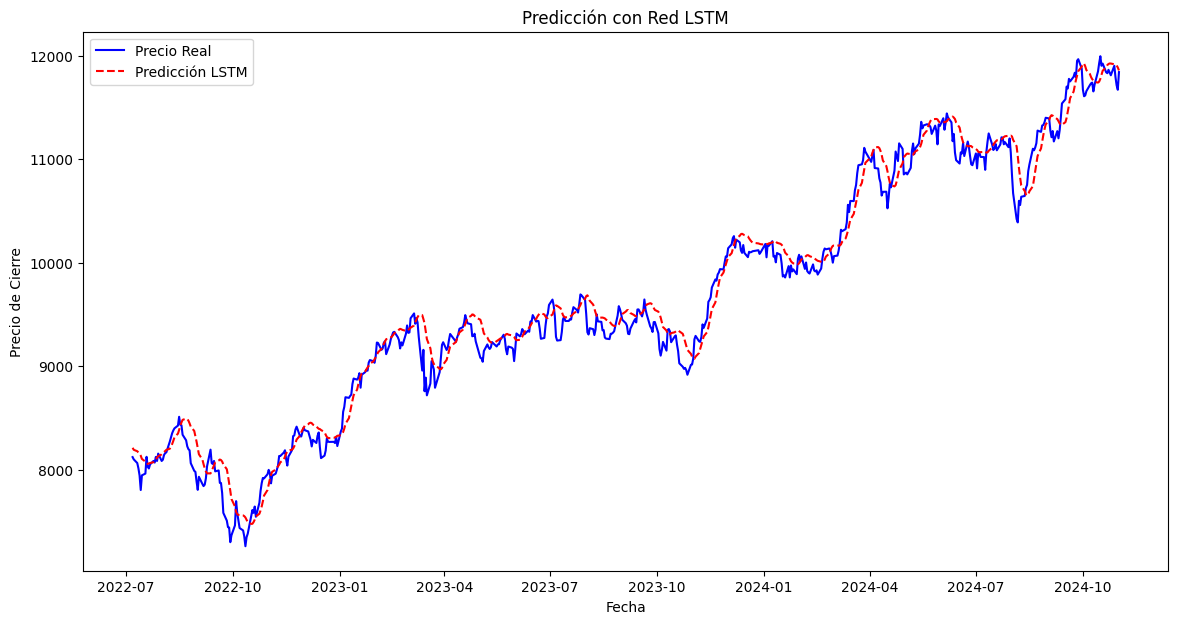

In [21]:
import matplotlib.pyplot as plt

# Graficar los resultados
plt.figure(figsize=(14, 7))
plt.plot(test.index[sequence_length:], y_test_actual, label='Precio Real', color='blue')
plt.plot(test.index[sequence_length:], predictions, label='Predicción LSTM', linestyle='--', color='red')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.title('Predicción con Red LSTM')
plt.legend()
plt.show()


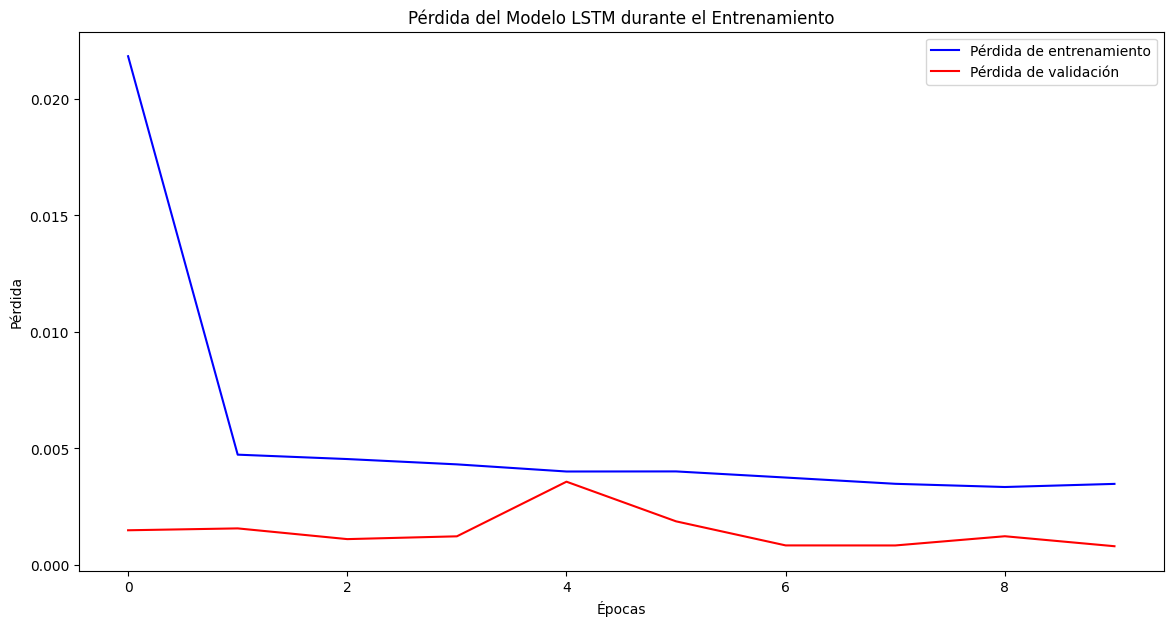

In [22]:
# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento', color='blue')
plt.plot(history.history['val_loss'], label='Pérdida de validación', color='red')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida del Modelo LSTM durante el Entrenamiento')
plt.legend()
plt.show()


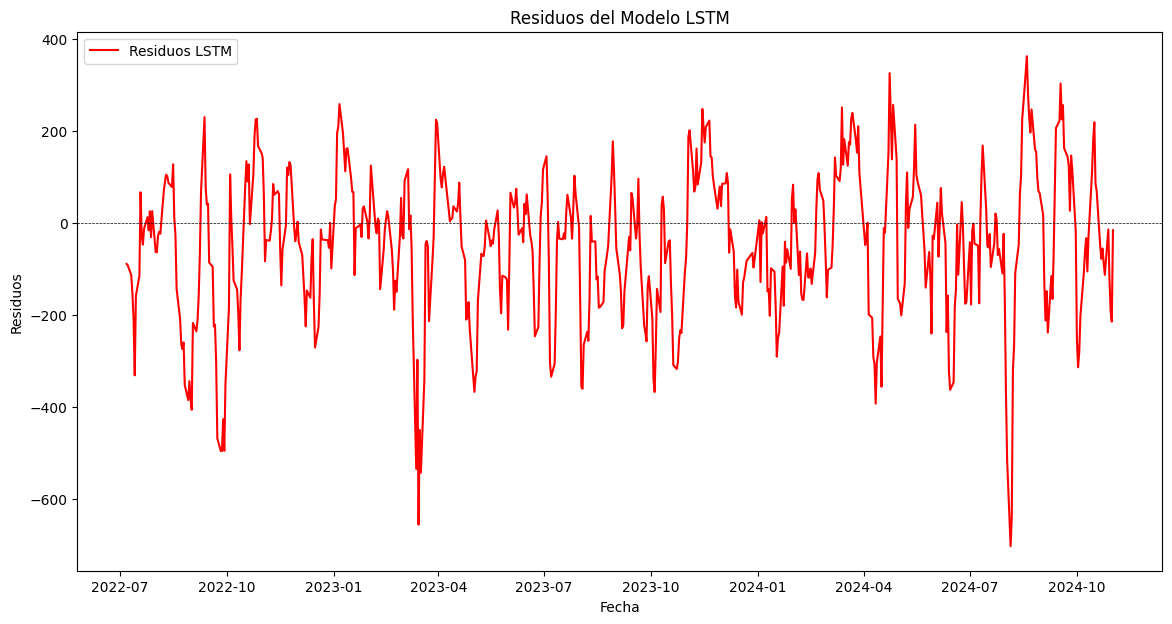

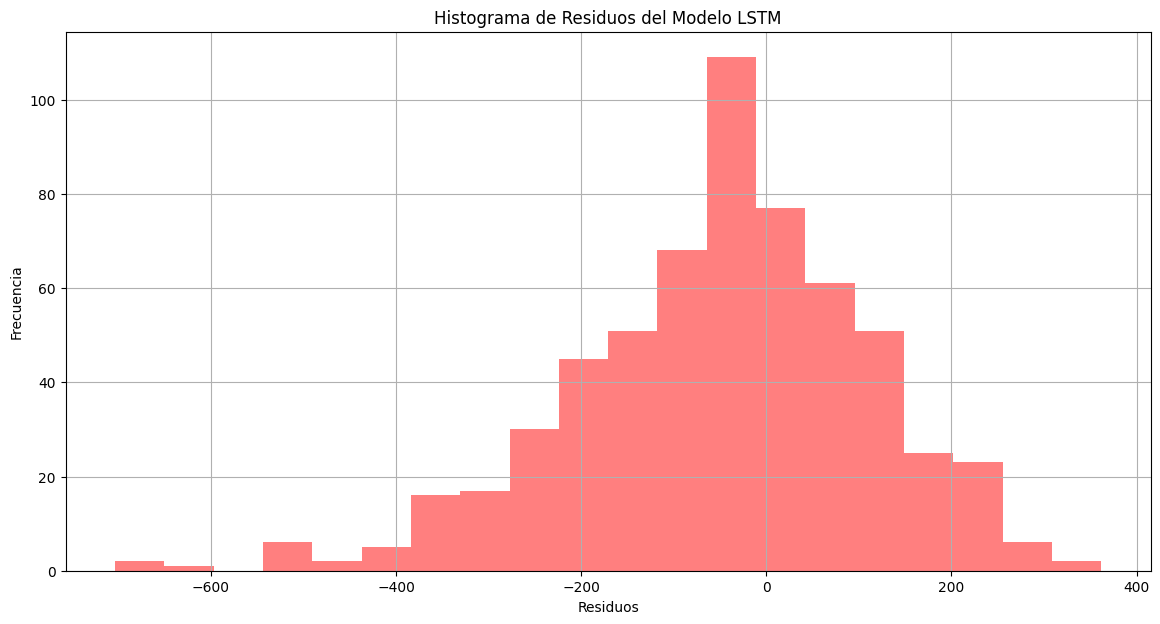

In [23]:
# Calcular los residuos
residuals_lstm = y_test_actual - predictions

# Graficar los residuos
plt.figure(figsize=(14, 7))
plt.plot(test.index[sequence_length:], residuals_lstm, label='Residuos LSTM', color='red')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.title('Residuos del Modelo LSTM')
plt.legend()
plt.show()

# Graficar histograma de los residuos
plt.figure(figsize=(14, 7))
plt.hist(residuals_lstm, bins=20, color='red', alpha=0.5)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos del Modelo LSTM')
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 36ms/step


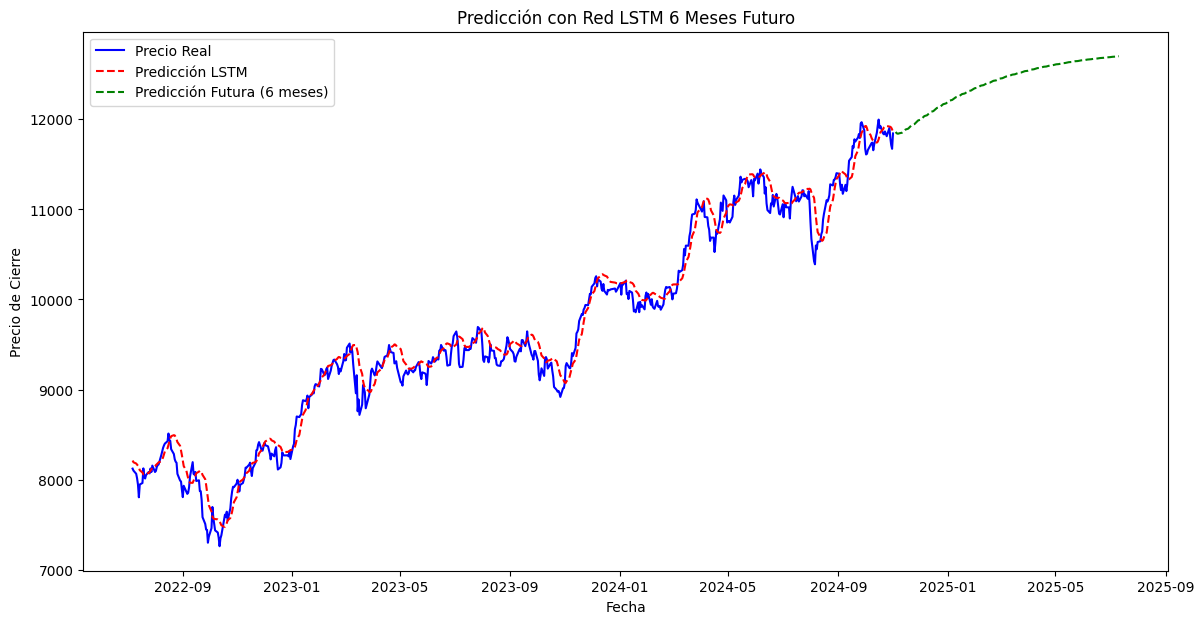

In [24]:
# Graficar los resultados de la predicción en conjunto con la predicción futura
plt.figure(figsize=(14, 7))

# Graficar los datos reales y las predicciones de la prueba
plt.plot(test.index[sequence_length:], y_test_actual, label='Precio Real', color='blue')
plt.plot(test.index[sequence_length:], predictions, label='Predicción LSTM', linestyle='--', color='red')

# Número de días a predecir (6 meses = 180 días)
n_days = 180

# Usar los últimos 60 días del conjunto de prueba para hacer las predicciones futuras
last_sequence = X_test[-1]  # Última secuencia del conjunto de prueba

# Realizar predicciones futuras
predictions_future = []
for _ in range(n_days):
    last_sequence = last_sequence.reshape((1, sequence_length, 1))  # Reshape necesario para la predicción
    next_pred = model.predict(last_sequence)  # Predecir el siguiente valor
    predictions_future.append(next_pred[0, 0])  # Agregar la predicción
    last_sequence = np.append(last_sequence[0][1:], next_pred).reshape(sequence_length, 1)  # Desplazar la ventana

# Invertir la normalización de las predicciones futuras
predictions_future = scaler.inverse_transform(np.array(predictions_future).reshape(-1, 1))

# Crear un índice de fechas futuras para las predicciones
future_dates = pd.date_range(start=test.index[-1], periods=n_days+1, freq='B')[1:]  # Usar días hábiles

# Graficar las predicciones futuras
plt.plot(future_dates, predictions_future, label='Predicción Futura (6 meses)', linestyle='--', color='green')

# Añadir etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.title('Predicción con Red LSTM 6 Meses Futuro')
plt.legend()
plt.show()

1/1 [==============================] - 0s 41ms/step


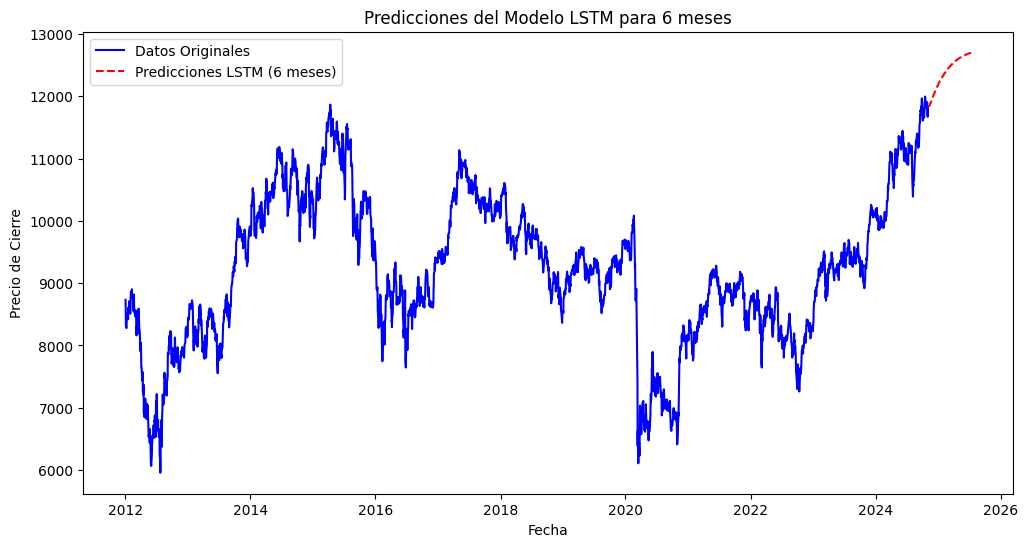

In [25]:
prediction_days = 180


# Crear una lista para almacenar las predicciones futuras
future_predictions = []

# Usar la última secuencia de datos de prueba para generar la primera predicción
last_sequence = X_test[-1]  # Última secuencia en X_test

# Generar predicciones día a día
for _ in range(prediction_days):
    # Hacer una predicción para el siguiente día
    next_pred = model.predict(np.expand_dims(last_sequence, axis=0))
    future_predictions.append(next_pred[0][0])  # Guardar la predicción
    
    # Actualizar la secuencia deslizante eliminando el primer valor y añadiendo la predicción al final
    last_sequence = np.vstack((last_sequence[1:], next_pred))

# Invertir la escala de las predicciones
future_predictions_unscaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Crear un rango de fechas para el próximo año
last_date = df.index[-1]  # Última fecha en el DataFrame original
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_days, freq='B')  # Días hábiles

# Crear un DataFrame para las predicciones futuras
predictions_df = pd.DataFrame(data=future_predictions_unscaled, index=future_dates, columns=['Predicted Close'])

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Datos Originales', color='blue')  # Datos históricos
plt.plot(predictions_df, label='Predicciones LSTM (6 meses)', color='red', linestyle='--')  # Predicciones futuras
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.title('Predicciones del Modelo LSTM para 6 meses')
plt.legend()
plt.show()

1/1 [==============================] - 0s 35ms/step


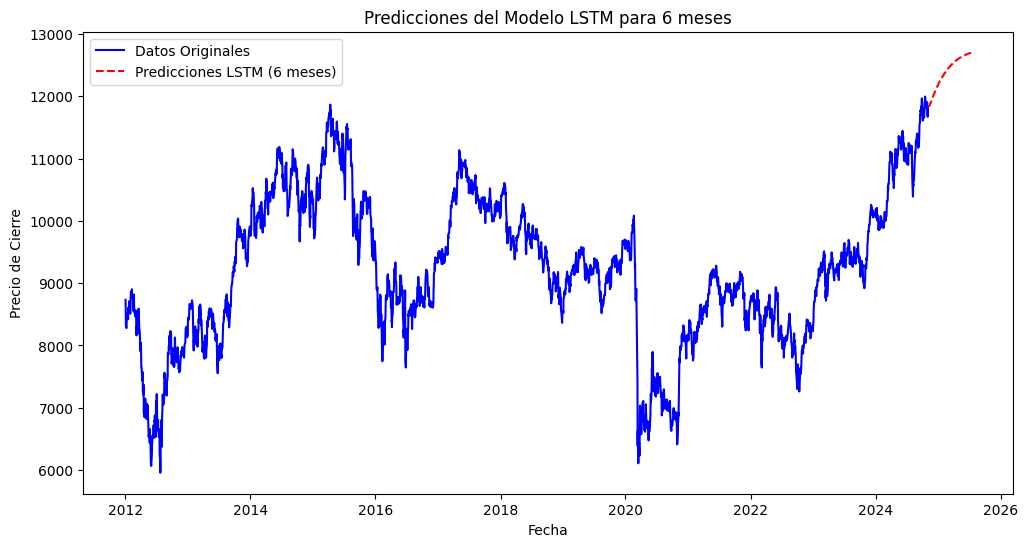

In [26]:
prediction_days = 180


# Crear una lista para almacenar las predicciones futuras
future_predictions = []

# Usar la última secuencia de datos de prueba para generar la primera predicción
last_sequence = X_test[-1]  # Última secuencia en X_test

# Generar predicciones día a día
for _ in range(prediction_days):
    # Hacer una predicción para el siguiente día
    next_pred = model.predict(np.expand_dims(last_sequence, axis=0))
    future_predictions.append(next_pred[0][0])  # Guardar la predicción
    
    # Actualizar la secuencia deslizante eliminando el primer valor y añadiendo la predicción al final
    last_sequence = np.vstack((last_sequence[1:], next_pred))

# Invertir la escala de las predicciones
future_predictions_unscaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Crear un rango de fechas para el próximo año
last_date = df.index[-1]  # Última fecha en el DataFrame original
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_days, freq='B')  # Días hábiles

# Crear un DataFrame para las predicciones futuras
predictions_df = pd.DataFrame(data=future_predictions_unscaled, index=future_dates, columns=['Predicted Close'])

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Datos Originales', color='blue')  # Datos históricos
plt.plot(predictions_df, label='Predicciones LSTM (6 meses)', color='red', linestyle='--')  # Predicciones futuras
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.title('Predicciones del Modelo LSTM para 6 meses')
plt.legend()
plt.show()